Savin, Nikitina, Dubenskiy

Romanenko project

<font color="green"> 1.1 and 1.2 are done here </font>

<span style="color:black; font-size: 12pt"></span>


In [69]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

# don't forget to upload utils file to the colab session
import warnings

warnings.filterwarnings('ignore')

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
pd.options.plotting.backend = "plotly"

import warnings
warnings.filterwarnings('ignore')

# # setting of the plotting style, registers pandas date converters for matplotlib and the default figure size
# import seaborn as sns
# sns.set_style("darkgrid")
# pd.plotting.register_matplotlib_converters()
# # Default figure size
# sns.mpl.rc("figure", figsize=(25, 5))
# sns.mpl.rc("font", size=14)

# I. Building Time Series Forecastability Index
Those Time Series that have about the same accuracy level should have the same $\color{red}{Forecastability~Index}$.



<img src = 'https://github.com/aromanenko/ATSF/blob/main/pic/Forecastability%20Index.png?raw=true' width = 500pt>

Forecastability index = Function_of_DemandPatterns(Velocity, Variability, Trend, Seasonality, Intermittency) x Horizon

If there is a set of time series, forecastablity index may be presented as table with columns


|FI| No of ts| Demand share|  


Goal of the project: build forecastablity index for particular set

https://www.kaggle.com/t/216ccba5311a44d8a6a8998534523cf7

## Steps to build FI
### 1. Generate segments for each attributes
 - 1.1. Demand Volume (3-groups) - see II.1 and II.2 below
 - 1.2. Demand Variability (volatility coefficient) (3 groups) see II.1 and II. 3 below
 - 1.3. Seasonality (0/1) see https://github.com/aromanenko/ts-segmentation/blob/main/timeseries_segmentation.py
 - 1.4. Trend (0/1) see https://github.com/aromanenko/ts-segmentation/blob/main/timeseries_segmentation.py
 - 1.5. Intermittency (0/1) https://github.com/aromanenko/ts-segmentation/blob/main/timeseries_segmentation.py

### 2. Define benchmark forecastability for eash 5-dim cell from 1
 - 2.1. Use naive forecast to generate forecast for each ts,  see https://github.com/aromanenko/ts-segmentation/blob/main/timeseries_forecasting.py
 - 2.2. Calculate WAPE metic for each 5-dim cell, see https://github.com/aromanenko/ATSF/blob/main/7_Loss%20Functions%20in%20Forecasting.ipynb
 - 2.3. Order all 5-dim cells on WAPE metric (see example below)

### 3. Aggregate 5-dim cells to clusters with similar forecastability
 - use abc-analysis, see II.1 below

In [70]:
# example of 2.3 step
import itertools

## cortesian product of all segments
fi_segments = [
   [1, 100, 1000],
   [0.1, 0.8, 2],
   [0, 1],
   [0, 1],
   [0, 1]
   ]

# table with all fi cells
fi_cells = pd.DataFrame([element for element in itertools.product(*fi_segments)], columns = ['Demand Volume', 'Demand Variability', 'Seasonality', 'Trend', 'Intermittency'])
fi_cells['WAPE'] = [np.random.random() for i in fi_cells.index] # fake WAPE generation, just for example, you have to calculate real WAPE at 2.2. step
fi_cells['WAPE_ci_l'] = fi_cells['WAPE']-0.1  # fake WAPE lower-ci generation, just for example, you have to calculate real WAPE ci at 2.2. step
fi_cells['WAPE_ci_u'] = fi_cells['WAPE']+0.1  # fake WAPE upper_ci generation, just for example, you have to calculate real WAPE ci at 2.2. step
fi_cells = fi_cells.sort_values(by = 'WAPE')

# draw CI plot example
x = tuple(range(0,fi_cells.shape[0]))
y = tuple(fi_cells.WAPE_ci_u.values)+tuple(fi_cells.WAPE_ci_l.values[::-1]) # upper, then lower reversed


# some plotly hints to make picture readable
fig = go.Figure([
    go.Scatter(
        x=x,
        y=fi_cells.WAPE,
        line=dict(color='rgb(0,100,80)'),
        mode='lines',
        text=['Demand volume {0}<br>Demand variable {1}<br>Seasonality {2}<br>Trend {3}<br>Intermittency {4}'.\
              format(x[1]['Demand Volume'], x[1]['Demand Variability'], x[1]['Seasonality'], x[1]['Trend'], x[1]['Intermittency'])
              for x in fi_cells.iterrows()],
        name='WAPE',
    ),
    go.Scatter(
        x=x+x[::-1], # x, then x reversed
        y=y ,
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=True,
        text=fi_cells['Demand Volume'],
        name = 'WAPE_ci'
    )
])
fig.update_layout(
    title=dict(
        text="Foreastability Index plot"
    ),
    xaxis=dict(
        title=dict(
            text="5-dim cell"
        )
    ),
    yaxis=dict(
        title=dict(
            text="WAPE"
        )
    ))

fig.show()

## 1. Generate Segments for each Attributes

### 1.1. Demand Volume segmentation

In [71]:
import pandas as pd
import numpy as np

# --- 1) Загружаем спрос (основной датасет) ---
ts_retail = pd.read_csv('train.csv')

# на всякий случай уберём мусорные колонки
ts_retail = ts_retail.drop(columns=['Unnamed: 0'], errors='ignore')

# приведём дату, если она есть (название зависит от твоего train.csv)
# попробуем самые частые варианты
for col in ['period_start_dt', 'date', 'Date', 'ds']:
    if col in ts_retail.columns:
        ts_retail[col] = pd.to_datetime(ts_retail[col], errors='coerce')
        break


# --- Идентификаторы "серий"
ts_id_columns = ['store_location_rk', 'product_rk']

ts_retail.head()


,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG
0,40369,309,2016-12-19,29.0,NaN,NaN,NaN,NaN,NaN,NaN
1,40370,309,2016-12-19,64.0,NaN,NaN,NaN,NaN,NaN,NaN
2,40372,309,2016-12-19,32.0,NaN,NaN,NaN,NaN,NaN,NaN
3,40373,309,2016-12-19,10.0,NaN,NaN,NaN,NaN,NaN,NaN
4,46272,309,2016-12-19,15.0,NaN,NaN,NaN,NaN,NaN,NaN


<font color="red"> Review: строится сегментация по "возрасту магазина", а надо по объем спроса по паре товар-магазин (store_location_rk, product_rk) </font>


In [72]:
import numpy as np
import matplotlib.pyplot as plt

def abc_analysis(values, return_idx=True, a_share=0.80, b_share=0.95,
                 plot=True, title="ABC analysis"):
    """
    ABC-анализ по вкладу в суммарный объем.
    Возвращает индексы элементов A/B/C и строит график
    """

    x = np.asarray(values, dtype=float)
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)

    n = len(x)
    if n == 0:
        res = {'A': np.array([], dtype=int), 'B': np.array([], dtype=int), 'C': np.array([], dtype=int)}
        res.update({'Aind': res['A'], 'Bind': res['B'], 'Cind': res['C']})
        return res

    order = np.argsort(-x)            # по убыванию
    sorted_x = x[order]
    total = sorted_x.sum()

    if total <= 0:
        res = {'A': np.array([], dtype=int), 'B': np.array([], dtype=int), 'C': np.arange(n, dtype=int)}
        res.update({'Aind': res['A'], 'Bind': res['B'], 'Cind': res['C']})
        return res

    cum_share = np.cumsum(sorted_x) / total
    frac_data = np.arange(1, n + 1) / n

    # границы по доле вклада (80% и 95% по умолчанию)
    i_ab = int(np.searchsorted(cum_share, a_share, side='left'))   # индекс границы A|B
    i_bc = int(np.searchsorted(cum_share, b_share, side='left'))   # индекс границы B|C

    # маски сегментов
    a_mask = np.zeros(n, dtype=bool); a_mask[:i_ab + 1] = True
    b_mask = np.zeros(n, dtype=bool); b_mask[i_ab + 1:i_bc + 1] = True
    c_mask = np.zeros(n, dtype=bool); c_mask[i_bc + 1:] = True

    A = order[a_mask]
    B = order[b_mask]
    C = order[c_mask]

    #ГРАФИК
    if plot:
        xA = frac_data[i_ab] if i_ab >= 0 and i_ab < n else 0.0
        yA = cum_share[i_ab] if i_ab >= 0 and i_ab < n else 0.0
        xB = frac_data[i_bc] if i_bc >= 0 and i_bc < n else 0.0
        yB = cum_share[i_bc] if i_bc >= 0 and i_bc < n else 0.0

        plt.figure(figsize=(10, 6))
        plt.title(title, fontsize=22)

        # data (зелёная)
        plt.plot(frac_data, cum_share, color='green', linewidth=2, label='data')

        # identity (синяя диагональ)
        plt.plot([0, 1], [0, 1], color='blue', linestyle='--', linewidth=2, label='identity')

        # uniform (серая пунктирная)
        plt.plot([0, 1], [1, 0], color='gray', linestyle='--', linewidth=2, label='uniform')

        # красные границы
        plt.axvline(xA, color='red', linewidth=2)
        plt.axhline(yA, color='red', linewidth=2)
        plt.axvline(xB, color='red', linewidth=2)
        plt.axhline(yB, color='red', linewidth=2)
        plt.scatter([xA, xB], [yA, yB], color='red', s=60, zorder=5)

        # подписи областей
        plt.text(max(0.06, xA * 0.35), max(0.15, yA * 0.45), "A", color='red', fontsize=26)
        plt.text(min(0.65, (xA + xB) / 2), 0.12, "B", color='red', fontsize=26)
        plt.text(min(0.85, xB + (1 - xB) * 0.35), 0.90, "C", color='red', fontsize=26)

        # подписи границ
        plt.text(xA * 0.7, min(0.95, yA + 0.08), "A|B", color='red', fontsize=16)
        plt.text(xB * 0.85, min(0.95, yB + 0.05), "B|C", color='red', fontsize=16)

        # n-подписи
        plt.text(max(0.03, xA * 0.25), max(0.15, yA * 0.35), f"n={len(A)}", color='black')
        plt.text(min(0.75, (xA + xB) / 2), 0.45, f"n={len(B)}", color='black')

        plt.xlabel("fraction of data")
        plt.ylabel("fraction of sum of largest data")
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.grid(True, alpha=0.35)
        plt.legend()
        plt.show()

    res = {'A': A, 'B': B, 'C': C}
    # алиасы
    res.update({'Aind': A, 'Bind': B, 'Cind': C})
    return res


In [73]:
ts_id_columns = ['store_location_rk', 'product_rk']


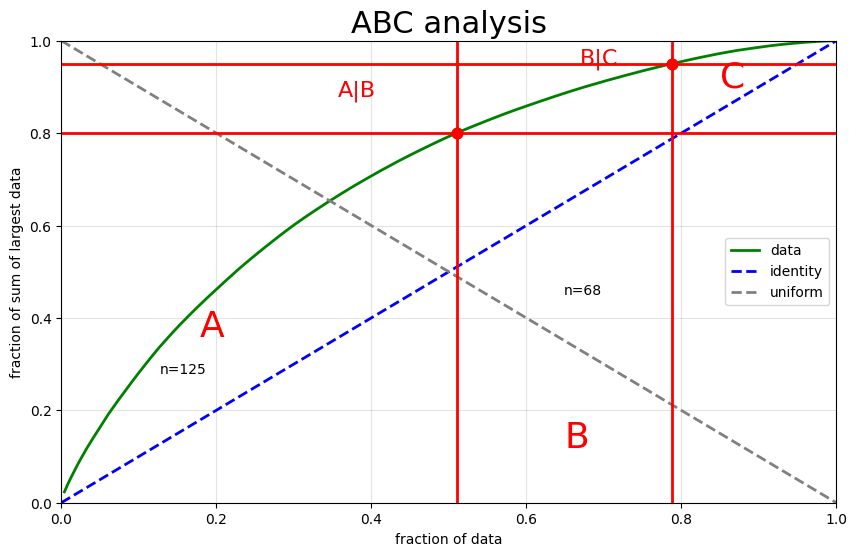

,store_location_rk,product_rk,demand_volume,volume_group
0,309,40369,206.0,C
1,309,40370,315.0,C
2,309,40372,150.0,C
3,309,40373,113.0,C
4,309,46272,51.0,C


In [74]:
# 1) объем спроса по паре store-product
ts_volume_values = ts_retail.groupby(ts_id_columns)['demand'].sum()

# 2) ABC-анализ (индексы A/B/C)
ts_volume_abc = abc_analysis(ts_volume_values.fillna(0).values, True)

# 3) таблица сегментов + метки
volume = ts_volume_values.reset_index(name='demand_volume')
volume['volume_group'] = 'C'
volume.loc[ts_volume_abc['A'], 'volume_group'] = 'A'
volume.loc[ts_volume_abc['B'], 'volume_group'] = 'B'

volume.head()


In [75]:
ts_retail = ts_retail.merge(
    volume[ts_id_columns + ['demand_volume', 'volume_group']],
    on=ts_id_columns,
    how='left'
)

ts_retail.head()


,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,demand_volume,volume_group
0,40369,309,2016-12-19,29.0,NaN,NaN,NaN,NaN,NaN,NaN,206.0,C
1,40370,309,2016-12-19,64.0,NaN,NaN,NaN,NaN,NaN,NaN,315.0,C
2,40372,309,2016-12-19,32.0,NaN,NaN,NaN,NaN,NaN,NaN,150.0,C
3,40373,309,2016-12-19,10.0,NaN,NaN,NaN,NaN,NaN,NaN,113.0,C
4,46272,309,2016-12-19,15.0,NaN,NaN,NaN,NaN,NaN,NaN,51.0,C


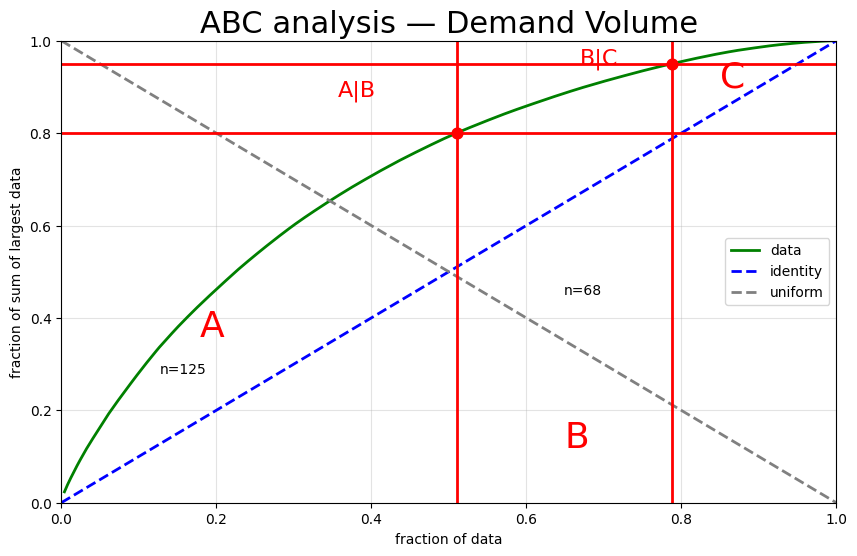

,store_location_rk,product_rk,demand_volume,volume_group
0,309,40369,206.0,C
1,309,40370,315.0,C
2,309,40372,150.0,C
3,309,40373,113.0,C
4,309,46272,51.0,C


volume_group
A    125
B     68
C     52
Name: count, dtype: int64


In [76]:
# 1.1

ts_id_columns = ['store_location_rk', 'product_rk']

# считаем объем спроса по каждой паре товар–магазин
volume = (
    ts_retail
    .groupby(ts_id_columns)['demand']
    .sum()
    .reset_index(name='demand_volume')
)

# ABC-анализ + график (рисует abc_analysis)
abc_vol = abc_analysis(
    volume['demand_volume'].fillna(0).values,
    True,
    plot=True,
    title="ABC analysis — Demand Volume"
)

# присваиваем группы A/B/C
volume['volume_group'] = 'C'
volume.loc[abc_vol['A'], 'volume_group'] = 'A'
volume.loc[abc_vol['B'], 'volume_group'] = 'B'

# (как было) присоединяем группы к исходным данным
ts_retail = ts_retail.merge(
    volume[ts_id_columns + ['demand_volume', 'volume_group']],
    on=ts_id_columns,
    how='left'
)

display(volume.head())
print(volume['volume_group'].value_counts())


### 1.2. Demand Variability Segments
<font color="red"> Review: строится сегментация по variability "возраста магазина", а надо относительно объема спроса по паре товар-магазин (store_location_rk, product_rk) </font>

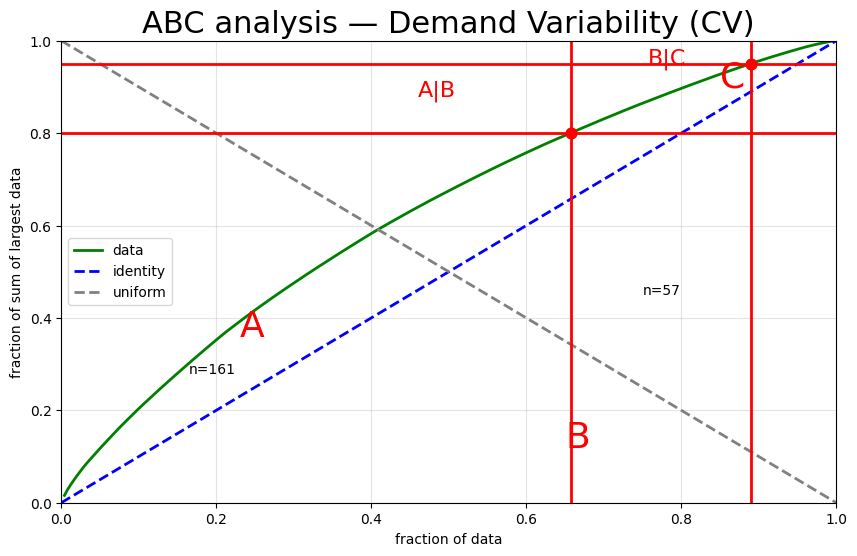

,store_location_rk,product_rk,demand_cv,variability_group
0,309,40369,0.613535,C
1,309,40370,0.512342,C
2,309,40372,0.537649,C
3,309,40373,0.558715,C
4,309,46272,0.254147,C


variability_group
A    161
B     57
C     27
Name: count, dtype: int64


In [77]:
# 1.2

g = ts_retail.groupby(ts_id_columns)['demand']

mean_d = g.mean()
std_d  = g.std(ddof=0)

ts_cv_values = (std_d / mean_d.replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)

# ABC-анализ + график
abc_var = abc_analysis(
    ts_cv_values.values,
    True,
    plot=True,
    title="ABC analysis — Demand Variability (CV)"
)

demand_var = ts_cv_values.reset_index(name='demand_cv')

# присваиваем группы A/B/C
demand_var['variability_group'] = 'C'
demand_var.loc[abc_var['A'], 'variability_group'] = 'A'
demand_var.loc[abc_var['B'], 'variability_group'] = 'B'

# присоединяем к исходным данным
ts_retail = ts_retail.merge(
    demand_var[ts_id_columns + ['demand_cv', 'variability_group']],
    on=ts_id_columns,
    how='left'
)

display(demand_var.head())
print(demand_var['variability_group'].value_counts())


In [78]:
ts_retail = ts_retail.merge(
    demand_var[ts_id_columns + ['demand_cv', 'variability_group']],
    on=ts_id_columns,
    how='left'
)

ts_retail.head()


,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,demand_volume_x,volume_group_x,demand_volume_y,volume_group_y,demand_cv_x,variability_group_x,demand_cv_y,variability_group_y
0,40369,309,2016-12-19,29.0,NaN,NaN,NaN,NaN,NaN,NaN,206.0,C,206.0,C,0.613535,C,0.613535,C
1,40370,309,2016-12-19,64.0,NaN,NaN,NaN,NaN,NaN,NaN,315.0,C,315.0,C,0.512342,C,0.512342,C
2,40372,309,2016-12-19,32.0,NaN,NaN,NaN,NaN,NaN,NaN,150.0,C,150.0,C,0.537649,C,0.537649,C
3,40373,309,2016-12-19,10.0,NaN,NaN,NaN,NaN,NaN,NaN,113.0,C,113.0,C,0.558715,C,0.558715,C
4,46272,309,2016-12-19,15.0,NaN,NaN,NaN,NaN,NaN,NaN,51.0,C,51.0,C,0.254147,C,0.254147,C


### 1.3. Seasonality segments

In [79]:
# put your code here

### 1.4. Trend segments (0/1)

In [80]:
# put your code here

1.5. Intermittency segments

In [81]:
# put your code here

<font color="red"> Review: не понимаю, зачем код ниже написан </font>

## Step 2. Define benchmark forecastability for eash 5-dim cell from 1


In [82]:
# put your code here

### 2.1. Use naive forecast to generate forecast for each ts

In [83]:
# put your code here


### 2.2. Calculate WAPE metic for each 5-dim cell


In [84]:
# put your code here

### 2.3. Order all 5-dim cells on WAPE metric

In [85]:
# put your code here

## 3. Aggregate 5-dim cells to clusters with similar forecastability

In [86]:
# put your code here
